<h2><b>A PSO-based deep feature selection method
for Pneumonia detection from Chest X-rays.</h2>


<h5>Fatemeh Ghanadi</h5>





# Preprocessing

- Libraries

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import sys
import random
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import warnings
warnings.filterwarnings('ignore')

from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score

from numpy import loadtxt
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# transfer learning

In [ ]:

phases = ['training', 'validation']

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# TL model for feature extraction
class ConvNet(nn.Module):
    def __init__(self, model, num_classes):
        super(ConvNet, self).__init__()
        self.base_model = nn.Sequential(*list(model.children())[:-1])
        self.linear1 = nn.Linear(in_features=2016, out_features=512) # in_features is various from model to model.
        self.linear2 = nn.Linear(in_features=512, out_features=num_classes)
        # self.linear3 = nn.Linear(in_features=256, out_features=num_classes)
        self.relu = nn.LeakyReLU()



    def forward(self, x):
        x = self.base_model(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        lin = self.relu(x)
        x = self.linear2(lin)

        return lin, x


# utility function for training CNN model
def train_model(model, criterion, optimizer, scheduler, data_loader, batch_size,val_batch_size, num_epochs=30):

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0

    for epoch in range(num_epochs):

        for phase in phases:
            if phase == 'training':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_corrects = 0

            for ii, (images, labels) in enumerate(data_loader[phase]):

                images = images.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'training'):
                    _, outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                epoch_corrects += torch.sum(preds == labels.data)
                epoch_loss += loss.item() * images.size(0)

            epoch_accuracy = epoch_corrects/len(data_loader[phase])
            epoch_loss /= len(data_loader[phase])

            # store statistics
            if phase == 'training':
                train_loss.append(epoch_loss)
                epoch_accuracy = epoch_accuracy / float(batch_size)
                train_acc.append(epoch_accuracy)
                scheduler.step()
            if phase == 'validation':
                val_loss.append(epoch_loss)
                epoch_accuracy = epoch_accuracy / float(val_batch_size)
                val_acc.append(epoch_accuracy)

            print(f'Epoch: [{epoch+1}/{num_epochs}] Phase: {phase} | Loss: {epoch_loss:.6f} Accuracy: {epoch_accuracy:.6f}')

            # deep copy the best model weights
            if phase == 'validation' and epoch_accuracy >= best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'====> Best accuracy reached so far at Epoch {epoch+1} Accuracy = {best_accuracy:.6f}')

        print('-------------------------------------------------------------------------')

    # training complete
    print(f'Best Validation Accuracy: {best_accuracy:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss.copy(),
        'train_acc': train_acc.copy(),
        'val_loss': val_loss.copy(),
        'val_acc': val_acc.copy()
    }

    return model, history


# utility function to evaluate model on dataset and extract features
def eval_model_extract_features(features, true_labels, model, dataloader, phase):

    conf_mat = torch.zeros(2, 2)

    with torch.no_grad():
        # for entire dataset
        n_correct = 0
        n_samples = 0

        model.eval()

        for images, labels in dataloader:

            images = images.to(device)
            labels = labels.to(device)

            true_labels.append(labels)

            ftrs, outputs = model(images)
            features.append(ftrs)

            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                conf_mat[t.long()][p.long()] += 1

            n_samples += labels.size(0)
            n_correct += (preds == labels).sum().item()

        accuracy = n_correct/float(n_samples)

        print(f'Accuracy of model on {phase} set = {(100.0 * accuracy):.4f} %')

    print(conf_mat)
    print(conf_mat.diag()/conf_mat.sum(1))
    return features, true_labels


def get_features(features, true_labels):
    ftrs = features.copy()
    lbls = true_labels.copy()

    for i in range(len(ftrs)):
        ftrs[i] = ftrs[i].cpu().numpy()

    for i in range(len(lbls)):
        lbls[i] = lbls[i].cpu().numpy()

    # convert to numpy array
    ftrs = np.array(ftrs)
    lbls = np.array(lbls)

    n_samples = ftrs.shape[0] * ftrs.shape[1]
    n_features = ftrs.shape[2]
    ftrs = ftrs.reshape(n_samples, n_features)

    n_lbls = lbls.shape[0]
    lbls = lbls.reshape(n_lbls)

    return ftrs, lbls

# KFold

In [ ]:
for i in range(1,6):
  print(f'Fold {i}')
  print('Validation : ')
  print(len(os.listdir(f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}/NORMAL')))
  print(len(os.listdir(f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}/PNEUMONIA')))
  print('Train : ')
  print(len(os.listdir(f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}/NORMAL')))
  print(len(os.listdir(f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}/PNEUMONIA')))
  print("------------------")

Fold 1
Validation : 
324
831
Train : 
1260
3317
------------------
Fold 2
Validation : 
321
831
Train : 
1266
3323
------------------
Fold 3
Validation : 
322
836
Train : 
1266
3329
------------------
Fold 4
Validation : 
322
835
Train : 
1265
3330
------------------
Fold 5
Validation : 
321
832
Train : 
608
3333
------------------


#models
https://pytorch.org/vision/stable/models.html

##ResNet50

In [ ]:
import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier as KNN




for i in range(1,2):

  # DIR_PATH ='/content/drive/MyDrive/pneumonia/data/KFold'

  TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}'
  VAL_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}'

  # image transformations
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])
  val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

  classes_to_idx = train_dataset.class_to_idx



  train_batch_size=32
  validation_batch_size=32

  learning_rate=0.0001
  num_classes=2
  num_epochs=20
  momentum=0

  phases = ['training', 'validation']

  device = None
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  # dataloaders
  data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=validation_batch_size,
                             shuffle=True,
                             num_workers=validation_batch_size)
  }
  for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')


  model = torchvision.models.resnet50(pretrained=True)




  model = ConvNet(model, num_classes)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # training CNN model
  start = time.time()
  print(f'Fold {i} :')
  model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size,validation_batch_size, num_epochs)
  torch.save(model,'/content/drive/MyDrive/resnet50.pth' )
  duration = time.time() - start
  print(f'Fold {i}, Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')



Length of training loader = 143
Length of validation loader = 37
Fold 1 :
Epoch: [1/20] Phase: training | Loss: 6.400593 Accuracy: 0.921984
Epoch: [1/20] Phase: validation | Loss: 5.729846 Accuracy: 0.912162
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.912162
-------------------------------------------------------------------------
Epoch: [2/20] Phase: training | Loss: 4.475117 Accuracy: 0.950393
Epoch: [2/20] Phase: validation | Loss: 3.648180 Accuracy: 0.935811
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.935811
-------------------------------------------------------------------------
Epoch: [3/20] Phase: training | Loss: 3.708591 Accuracy: 0.956512
Epoch: [3/20] Phase: validation | Loss: 5.867679 Accuracy: 0.893581
-------------------------------------------------------------------------
Epoch: [4/20] Phase: training | Loss: 3.386070 Accuracy: 0.961538
Epoch: [4/20] Phase: validation | Loss: 5.481812 Accuracy: 0.899493
------------------------------------

##ResNet101, 44.5M

In [ ]:
import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier as KNN




for i in range(1,2):

  # DIR_PATH ='/content/drive/MyDrive/pneumonia/data/KFold'

  TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}'
  VAL_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}'

  # image transformations
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])
  val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

  classes_to_idx = train_dataset.class_to_idx



  train_batch_size=32
  validation_batch_size=32

  learning_rate=0.0001
  num_classes=2
  num_epochs=20
  momentum=0

  phases = ['training', 'validation']

  device = None
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  # dataloaders
  data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=validation_batch_size,
                             shuffle=True,
                             num_workers=validation_batch_size)
  }
  for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')


  model = torchvision.models.resnet101(pretrained=True)




  model = ConvNet(model, num_classes)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # training CNN model
  start = time.time()
  print(f'Fold {i} :')
  model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size,validation_batch_size, num_epochs)
  # torch.save(model,'/content/drive/MyDrive/resnet101.pth' )
  duration = time.time() - start
  print(f'Fold {i}, Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')



Length of training loader = 143
Length of validation loader = 37
Fold 1 :
Epoch: [1/20] Phase: training | Loss: 6.477866 Accuracy: 0.915865
Epoch: [1/20] Phase: validation | Loss: 5.399361 Accuracy: 0.907095
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.907095
-------------------------------------------------------------------------
Epoch: [2/20] Phase: training | Loss: 5.032874 Accuracy: 0.940996
Epoch: [2/20] Phase: validation | Loss: 3.701490 Accuracy: 0.931588
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.931588
-------------------------------------------------------------------------
Epoch: [3/20] Phase: training | Loss: 3.853620 Accuracy: 0.953234
Epoch: [3/20] Phase: validation | Loss: 9.307151 Accuracy: 0.891047
-------------------------------------------------------------------------
Epoch: [4/20] Phase: training | Loss: 3.576317 Accuracy: 0.954764
Epoch: [4/20] Phase: validation | Loss: 7.001890 Accuracy: 0.891892
------------------------------------

RuntimeError: ignored

In [ ]:
torch.save(model,'/content/drive/MyDrive/resnet101.pth' )


In [ ]:
model = torch.load('/content/drive/MyDrive/pneumonia/resnet101.pth')
model.eval()

##EfficientNet_B6_Weights.DEFAULT,43M

In [ ]:
import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier as KNN




for i in range(1,2):

  # DIR_PATH ='/content/drive/MyDrive/pneumonia/data/KFold'

  TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}'
  VAL_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}'

  # image transformations
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])
  val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

  classes_to_idx = train_dataset.class_to_idx



  train_batch_size=32
  validation_batch_size=32

  learning_rate=0.0001
  num_classes=2
  num_epochs=20
  momentum=0

  phases = ['training', 'validation']

  device = None
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  # dataloaders
  data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=validation_batch_size,
                             shuffle=True,
                             num_workers=validation_batch_size)
  }
  for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')




  weights = torchvision.models.EfficientNet_B6_Weights.DEFAULT
  model = torchvision.models.efficientnet_b6(weights=weights)
  # model.eval()


  model = ConvNet(model, num_classes)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # training CNN model
  start = time.time()
  print(f'Fold {i} :')
  model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size,validation_batch_size, num_epochs)
  torch.save(model,'/content/drive/MyDrive/EfficientNet_B6.pth' )
  duration = time.time() - start
  print(f'Fold {i}, Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')



Length of training loader = 143
Length of validation loader = 37
Fold 1 :
Epoch: [1/20] Phase: training | Loss: 8.569421 Accuracy: 0.903628
Epoch: [1/20] Phase: validation | Loss: 7.138949 Accuracy: 0.885980
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.885980
-------------------------------------------------------------------------
Epoch: [2/20] Phase: training | Loss: 4.474931 Accuracy: 0.951486
Epoch: [2/20] Phase: validation | Loss: 10.097418 Accuracy: 0.839527
-------------------------------------------------------------------------
Epoch: [3/20] Phase: training | Loss: 3.909803 Accuracy: 0.958916
Epoch: [3/20] Phase: validation | Loss: 7.282250 Accuracy: 0.884291
-------------------------------------------------------------------------
Epoch: [4/20] Phase: training | Loss: 3.649466 Accuracy: 0.962631
Epoch: [4/20] Phase: validation | Loss: 5.118710 Accuracy: 0.915541
====> Best accuracy reached so far at Epoch 4 Accuracy = 0.915541
-----------------------------------

## regnet_y_8gf*,  39.4M

In [ ]:
import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier as KNN




for i in range(1,2):

  # DIR_PATH ='/content/drive/MyDrive/pneumonia/data/KFold'

  TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}'
  VAL_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}'

  # image transformations
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])
  val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

  classes_to_idx = train_dataset.class_to_idx



  train_batch_size=32
  validation_batch_size=32

  learning_rate=0.0001
  num_classes=2
  num_epochs=20
  momentum=0

  phases = ['training', 'validation']

  device = None
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  # dataloaders
  data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=validation_batch_size,
                             shuffle=True,
                             num_workers=validation_batch_size)
  }
  for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')




  weights = torchvision.models.RegNet_Y_8GF_Weights.IMAGENET1K_V2.DEFAULT
  model = torchvision.models.regnet_y_8gf(weights=weights)
  model.eval()


  model = ConvNet(model, num_classes)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # training CNN model
  start = time.time()
  print(f'Fold {i} :')
  model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size,validation_batch_size, num_epochs)
  torch.save(model,'/content/drive/MyDrive/regnet_y_8gf.pth' )
  duration = time.time() - start
  print(f'Fold {i}, Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')



Length of training loader = 143
Length of validation loader = 37
Fold 1 :
Epoch: [1/20] Phase: training | Loss: 7.024991 Accuracy: 0.908435
Epoch: [1/20] Phase: validation | Loss: 4.256451 Accuracy: 0.914696
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.914696
-------------------------------------------------------------------------
Epoch: [2/20] Phase: training | Loss: 3.808928 Accuracy: 0.957823
Epoch: [2/20] Phase: validation | Loss: 3.406841 Accuracy: 0.929899
====> Best accuracy reached so far at Epoch 2 Accuracy = 0.929899
-------------------------------------------------------------------------
Epoch: [3/20] Phase: training | Loss: 3.312169 Accuracy: 0.959135
Epoch: [3/20] Phase: validation | Loss: 4.873380 Accuracy: 0.914696
-------------------------------------------------------------------------
Epoch: [4/20] Phase: training | Loss: 2.743969 Accuracy: 0.968094
Epoch: [4/20] Phase: validation | Loss: 4.447082 Accuracy: 0.926520
------------------------------------

In [ ]:
history['val_acc']

[tensor(0.9147, device='cuda:0'),
 tensor(0.9299, device='cuda:0'),
 tensor(0.9147, device='cuda:0'),
 tensor(0.9265, device='cuda:0'),
 tensor(0.9341, device='cuda:0'),
 tensor(0.9468, device='cuda:0'),
 tensor(0.9485, device='cuda:0'),
 tensor(0.9417, device='cuda:0'),
 tensor(0.9451, device='cuda:0'),
 tensor(0.9485, device='cuda:0'),
 tensor(0.9510, device='cuda:0'),
 tensor(0.9493, device='cuda:0'),
 tensor(0.9519, device='cuda:0'),
 tensor(0.9510, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9493, device='cuda:0'),
 tensor(0.9510, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9493, device='cuda:0'),
 tensor(0.9519, device='cuda:0')]

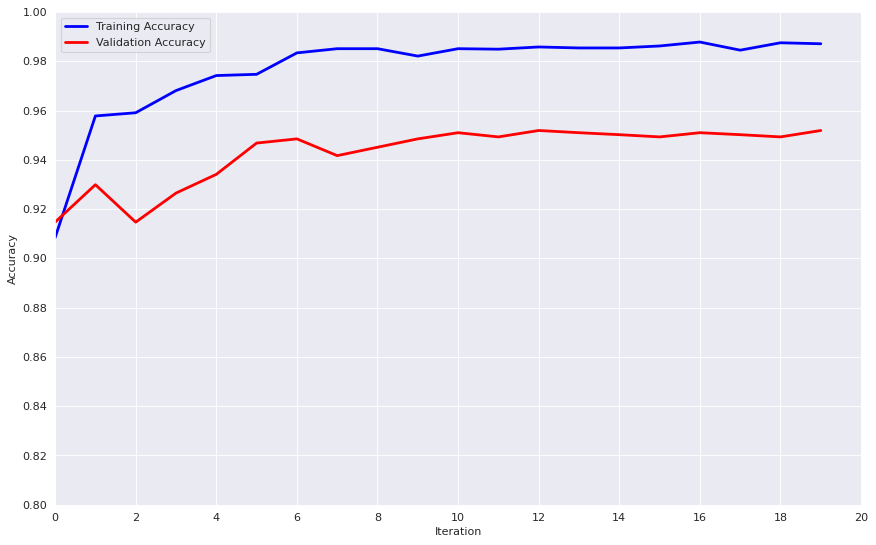

In [ ]:
# plot acc
sns.set_style("darkgrid")
plt.figure(figsize=(13, 8), dpi=80)
plt.subplot(111)

plt.plot(train_acc, color="blue", linewidth=2.5, linestyle="-", label='Training Accuracy')
plt.plot(val_acc, color="red", linewidth=2.5, linestyle="-", label='Validation Accuracy')

plt.xlim(0, 20)
plt.xticks(np.linspace(0.0,20.0, 11))

plt.ylim(0.8,1.0)
plt.yticks(np.linspace(0.8, 1.0, 11))

plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.legend()

# Save the plot in eps format
plt.savefig('ACC_regnet_.eps', format='eps')

# Save the plot in high-quality PNG format
plt.savefig('ACC_regnet_.png', dpi=300)

# Save the plot in high-quality JPEG format
plt.savefig('ACC_regnet_.png', dpi=300)
plt.show()

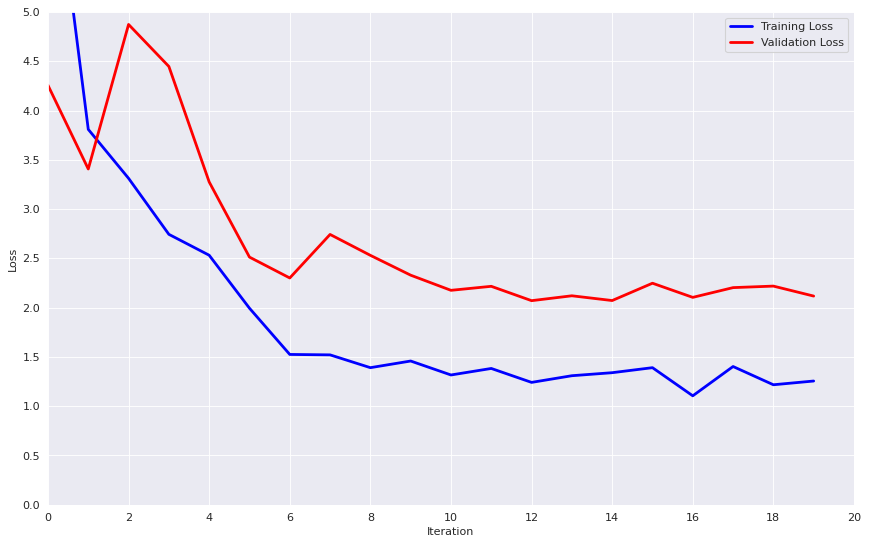

In [ ]:
# plot loss

sns.set_style("darkgrid")
plt.figure(figsize=(13, 8), dpi=80)
plt.subplot(111)

plt.plot(train_loss, color="blue", linewidth=2.5, linestyle="-",label='Training Loss')
plt.plot(val_loss, color="red", linewidth=2.5, linestyle="-", label='Validation Loss')

plt.xlim(0, 20)
plt.xticks(np.linspace(0.0,20.0, 11))

plt.ylim(0, 5.0)
plt.yticks(np.linspace(0.0, 5.0, 11))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()

# Save the plot in eps format
plt.savefig('LOSS_regnet_.eps', format='eps')

# Save the plot in high-quality PNG format
plt.savefig('LOSS_regnet_.png', dpi=300)

# Save the plot in high-quality JPEG format
plt.savefig('LOSS_regnet_.png', dpi=300)
plt.show()

##RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1, 83.6M

In [ ]:


import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier as KNN




for i in range(1,2):

  # DIR_PATH ='/content/drive/MyDrive/pneumonia/data/KFold'

  TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold{i}'
  VAL_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/Fold{i}'

  # image transformations
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])
  val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

  classes_to_idx = train_dataset.class_to_idx



  train_batch_size=32
  validation_batch_size=32

  learning_rate=0.0001
  num_classes=2
  num_epochs=20
  momentum=0

  phases = ['training', 'validation']

  device = None
  if torch.cuda.is_available():
    device = torch.device('cuda')
  else:
    device = torch.device('cpu')

  # dataloaders
  data_loader = {
    'training': DataLoader(dataset=train_dataset,
                           batch_size=train_batch_size,
                           shuffle=True,
                           num_workers=4),

    'validation': DataLoader(dataset=val_dataset,
                             batch_size=validation_batch_size,
                             shuffle=True,
                             num_workers=validation_batch_size)
  }
  for phase in phases:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')



# RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1

  weights = torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
  model = torchvision.models.regnet_y_16gf(weights=weights)
  model.eval()


  model = ConvNet(model, num_classes)
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # training CNN model
  start = time.time()
  print(f'Fold {i} :')
  model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, data_loader, train_batch_size,validation_batch_size, num_epochs)
  torch.save(model,'/content/drive/MyDrive/regnet_y_16gf.pth' )
  duration = time.time() - start
  print(f'Fold {i}, Training complete in {(duration // 60):.0f}mins {(duration % 60):.0f}s')



Length of training loader = 143
Length of validation loader = 37
Fold 1 :
Epoch: [1/20] Phase: training | Loss: 6.600331 Accuracy: 0.920455
Epoch: [1/20] Phase: validation | Loss: 6.043609 Accuracy: 0.913851
====> Best accuracy reached so far at Epoch 1 Accuracy = 0.913851
-------------------------------------------------------------------------
Epoch: [2/20] Phase: training | Loss: 4.172295 Accuracy: 0.951705
Epoch: [2/20] Phase: validation | Loss: 6.627282 Accuracy: 0.889358
-------------------------------------------------------------------------
Epoch: [3/20] Phase: training | Loss: 3.827784 Accuracy: 0.957823
Epoch: [3/20] Phase: validation | Loss: 3.405779 Accuracy: 0.949324
====> Best accuracy reached so far at Epoch 3 Accuracy = 0.949324
-------------------------------------------------------------------------
Epoch: [4/20] Phase: training | Loss: 3.095538 Accuracy: 0.967220
Epoch: [4/20] Phase: validation | Loss: 10.205447 Accuracy: 0.879223
-----------------------------------

## Load Selected Model

In [ ]:
model = model = torch.load('/content/drive/MyDrive/regnet_y_8gf.pth')
model.eval()

ConvNet(
  (base_model): Sequential(
    (0): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(224, 224, kernel_size=(3, 3), stri

# Getting Features

In [ ]:
from torch.utils.data import Dataset, DataLoader

# extract features

############### All Data




TRAIN_DIR_PATH = f'/content/drive/MyDrive/pneumonia/data/KFold/TrainFold1'

  # image transformations
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR_PATH, transform=transformations['train'])

features = []
true_labels = []
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=4)
# training set features

features, true_labels = eval_model_extract_features(features, true_labels, model, dataloader=train_loader, phase='training')
X, y = get_features(features, true_labels)




Accuracy of model on training set = 99.0166 %
tensor([[1235.,   25.],
        [  20., 3296.]])
tensor([0.9802, 0.9940])


In [ ]:

VAL_DIR_PATH = '/content/drive/MyDrive/pneumonia/data/KFold/Fold1'

  # image transformations
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(
            degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
  }

val_dataset = torchvision.datasets.ImageFolder(VAL_DIR_PATH, transform=transformations['val'])

features = []
true_labels = []
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=4)
# training set features

features, true_labels = eval_model_extract_features(features, true_labels, model, dataloader=val_loader, phase='validation')
vX, vy = get_features(features, true_labels)


Accuracy of model on validation set = 97.5758 %
tensor([[316.,   8.],
        [ 20., 811.]])
tensor([0.9753, 0.9759])


# Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# mi_scores = make_mi_scores(X, y,'auto')


In [ ]:
mi_scores = make_mi_scores(X, y,'auto')
mi_scores

136    0.553991
17     0.553848
56     0.553711
349    0.553174
266    0.553068
         ...   
407    0.026816
344    0.022722
365    0.012293
326    0.010706
408    0.004895
Name: MI Scores, Length: 512, dtype: float64

In [ ]:
mi_scores_arr=[0]*512
for i in range(0,512):
  mi_scores_arr[i]=mi_scores[i]



- find best #N features for initializing agents

In [ ]:

# printing original list
print("The original list is : " + str(mi_scores_arr))

# initialize N
N = 256

# Indices of N largest elements in list
# using sorted() + lambda + list slicing
max_indices = sorted(range(len(mi_scores_arr)), key = lambda sub: mi_scores_arr[sub])[-N:]

# printing result
print("Indices list of max N elements is : " + str(max_indices))
print("len max_indices :"+ str(len(max_indices)))

The original list is : [0.5526838841622563, 0.5402434361491988, 0.5422073066476578, 0.3831181176313123, 0.3680719967707722, 0.4803240862268048, 0.3032971615039308, 0.5450989711051122, 0.5492249983974649, 0.5447843008203002, 0.5105031453381574, 0.5430735176011385, 0.527573026406774, 0.549637051118804, 0.5456815909849393, 0.5483552815088988, 0.5512592940570773, 0.5538477093071226, 0.5343598426953484, 0.5466892393110641, 0.534181451408978, 0.5515510374654262, 0.5448637437259425, 0.4363592588618488, 0.5374363305833114, 0.5381053045300312, 0.532619354473459, 0.2666275088638379, 0.5230485162831862, 0.542295113745002, 0.5478606393167009, 0.5456278247667665, 0.5432173410988259, 0.39610267205795147, 0.5470145541177693, 0.2995351017751764, 0.0534373935009862, 0.5198098556436257, 0.5372581740122317, 0.5475229883981179, 0.5427257483680634, 0.5369280201261777, 0.27873116028703127, 0.5479664759857652, 0.12017773227597939, 0.5439007565919827, 0.5327661946163218, 0.18408943469697192, 0.546201209381299

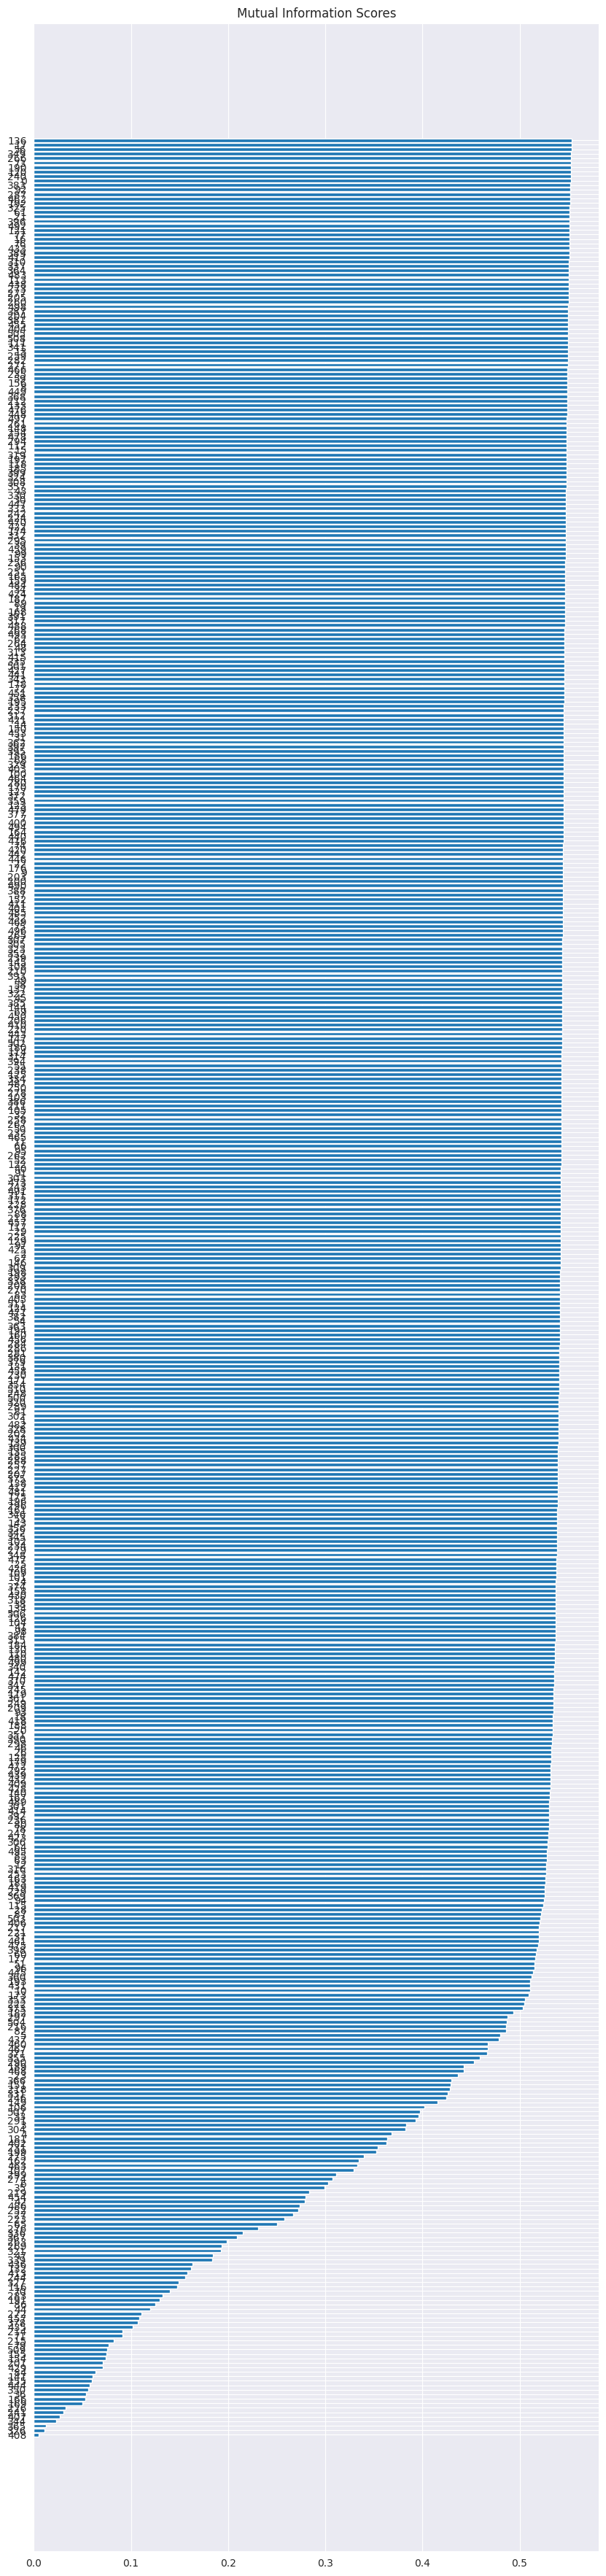

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 45))
plot_mi_scores(mi_scores)

In [ ]:
initial_solution=[0]*512
for ind in max_indices:
  initial_solution[ind]=1
np.sum(initial_solution)

256

In [ ]:
#[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]

#Improved PSO (Customized For Binary Feature Selection)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import time

# Record the current time in seconds
start_time = time.time()




def xor(arr1, arr2):
  result=[0]*len(arr1)
  for i in range(len(arr1)):
    if arr1[i]==arr2[i]:
      result[i]=0
    else:
      result[i]=1
  return result


def multiply(c, arr1):
  result=[0]*len(arr1)
  for i in range(len(arr1)):
    result[i]=c*arr1[i]
  return result

def multiply_arr(arr1,arr2):
  result=[0]*len(arr1)
  for i in range(len(arr1)):
    result[i]=arr1[i]*arr2[i]
  return result

def add(arr1, arr2):
  result=[0]*len(arr1)
  for i in range(len(arr1)):
    result[i]=arr1[i]+arr2[i]
  return result

def make_binary(arr):
  result=[0]*len(arr)
  for i in range(len(arr)):
    if arr[i]>=0.5:
      result[i]=1
    else:
      result[i]=0
  return result

class Particle:
    def __init__(self, num_features):
        self.position = np.zeros(num_features)
        self.velocity = np.zeros(num_features)
        self.best_position = np.zeros(num_features)
        self.best_fitness = 0.0


class PSOFeatureSelection:
    def __init__(self, num_particles, num_iterations, num_features, X_train, y_train, X_val, y_val):
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.num_features = num_features
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.particles = []

    def initialize_particles(self,init_solution):
        c=0
        for _ in range(self.num_particles):
          if random.random()<0.80:
            particle = Particle(self.num_features)
            particle.position = np.random.choice([0, 1], size=self.num_features)
            particle.velocity = np.random.choice([0, 1], size=self.num_features)
            self.particles.append(particle)
          else:
            particle = Particle(self.num_features)
            particle.position = np.array(init_solution)
            particle.velocity = np.random.choice([0, 1], size=self.num_features)
            self.particles.append(particle)
            c+=1
        print(f'{c} particles initialized.')



    def evaluate_fitness(self, particle:Particle,global_best_acc):
        selected_features = np.where(particle.position)[0]
        X_train_selected = self.X_train[:, selected_features]
        X_val_selected = self.X_val[:, selected_features]

        # Create and train a decision tree classifier
        # clf = DecisionTreeClassifier()
        # clf.fit(X_train_selected, self.y_train)

        # clf = XGBClassifier()
        # clf.fit(X_train_selected, self.y_train)

        clf = KNN()
        clf.fit(X_train_selected, self.y_train)

        # clf = svm.SVC()
        # clf.fit(X_train_selected, self.y_train)

        # Predict using the validation set
        y_pred = clf.predict(X_val_selected)

        # Calculate accuracy as the acc value
        acc = accuracy_score(self.y_val, y_pred)


        if acc < 0.98: # IF GBEST_ACC >= THRESHOLD AND CURRENT_PARTICLE_ACC < THRESHOLD , THEN CURRENT_PARTICLE_FIT = -1
            fitness= acc
        else:          # IF GBEST_ACC >= THRESHOLD AND CURRENT_PARTICLE_ACC >= THRESHOLD , THEN CURRENT_PARTICLE_FIT = 2 - (#Features / NUM_TOTAL_FEATURES)
            fitness = 2 - np.sum(particle.position)/(512)

        return acc,fitness

    def update_particle(self, particle, global_best_position, inertia_weight,global_best_acc):

        # Update velocity
        v=multiply(inertia_weight , particle.velocity )
        p=xor(particle.best_position , particle.position)
        g=xor(global_best_position , particle.position)

        vv=add(v,multiply_arr(np.random.uniform(low=-1, high=1, size=(self.num_features,)) ,p))
        vvv=add(vv,multiply_arr(np.random.rand(self.num_features) ,g))

        particle.velocity = make_binary(vvv)


        # Update position
        particle.position = xor(particle.position,particle.velocity)


        # Evaluate acc
        acc,fitness = self.evaluate_fitness(particle,global_best_acc)

        # Update personal best
        if fitness > particle.best_fitness:
            particle.best_fitness = fitness
            particle.best_position = particle.position.copy()

        return acc

    def search(self):
        global_best_fitness = 0.0
        global_best_acc = 0.0
        global_best_position = np.zeros(self.num_features)

        for particle in self.particles:

            acc,fitness = self.evaluate_fitness(particle,global_best_acc)


            if fitness > global_best_fitness:

                global_best_acc=acc
                global_best_fitness = fitness
                global_best_position = particle.position.copy()

        inertia_weight=1
        fit_curve=[]
        acc_curve=[]
        solution_size=[]
        for it in range(self.num_iterations):

            if it%5==0 and it !=0:
              inertia_weight =inertia_weight-1/20  #  adaptive inertia_weight
              if inertia_weight < 0.25 :
                inertia_weight=0.25
              print(f'------------- inertia_weight : {inertia_weight}')

            pi=0
            for particle in self.particles:
                acc=self.update_particle(particle, global_best_position, inertia_weight,global_best_acc)

                # Update global best
                if particle.best_fitness > global_best_fitness:
                    global_best_acc=acc
                    global_best_fitness = particle.best_fitness
                    global_best_position = particle.best_position.copy()



                print(f'[{pi}] --- PBEST_FIT : {particle.best_fitness}  ')
                pi+=1


            fit_curve.append(global_best_fitness)
            acc_curve.append(global_best_acc)
            solution_size.append(np.sum(particle.position))
            print(f'-------------- Iteration {it} ')
            print(f'-------------- GBest FIT : {global_best_fitness}')
            print(f'-------------- GBest ACC : {global_best_acc}')
            print(f'-------------- GBest Size : {np.sum(global_best_position)}')
            print(f'-------------- GBest Position : {global_best_position}')


        return global_best_position, fit_curve, acc_curve, solution_size


# Example usage
num_particles = 100
num_iterations =100
num_features = 512

# Assuming you have X_train, y_train, X_val, y_val datasets
pso = PSOFeatureSelection(num_particles, num_iterations, num_features, X, y, vX, vy)
pso.initialize_particles(initial_solution)
selected_features ,fit_curve, acc_curve, solution_size= pso.search()

print("Selected Features:", np.where(selected_features)[0])




# Calculate the elapsed time in seconds
elapsed_time = time.time() - start_time

print(f"Elapsed time: {elapsed_time} seconds")


Streaming output truncated to the last 5000 lines.
[60] --- PBEST_FIT : 0.9792207792207792  
[61] --- PBEST_FIT : 0.9792207792207792  
[62] --- PBEST_FIT : 0.9774891774891775  
[63] --- PBEST_FIT : 1.5546875  
[64] --- PBEST_FIT : 0.9792207792207792  
[65] --- PBEST_FIT : 0.9783549783549783  
[66] --- PBEST_FIT : 1.544921875  
[67] --- PBEST_FIT : 1.4921875  
[68] --- PBEST_FIT : 0.9783549783549783  
[69] --- PBEST_FIT : 0.9783549783549783  
[70] --- PBEST_FIT : 0.9792207792207792  
[71] --- PBEST_FIT : 0.9792207792207792  
[72] --- PBEST_FIT : 1.5234375  
[73] --- PBEST_FIT : 0.9792207792207792  
[74] --- PBEST_FIT : 1.494140625  
[75] --- PBEST_FIT : 0.9792207792207792  
[76] --- PBEST_FIT : 1.552734375  
[77] --- PBEST_FIT : 0.9792207792207792  
[78] --- PBEST_FIT : 0.9792207792207792  
[79] --- PBEST_FIT : 0.9792207792207792  
[80] --- PBEST_FIT : 0.9783549783549783  
[81] --- PBEST_FIT : 0.9783549783549783  
[82] --- PBEST_FIT : 0.9783549783549783  
[83] --- PBEST_FIT : 0.97748917

In [ ]:
sf=np.where(selected_features)[0]
len(X[:, sf][0])

163

In [ ]:
fit_curve

[0.9783549783549783,
 0.9800865800865801,
 0.9800865800865801,
 0.9800865800865801,
 0.9800865800865801,
 0.9800865800865801,
 0.9800865800865801,
 1.482421875,
 1.482421875,
 1.482421875,
 1.4921875,
 1.4921875,
 1.4921875,
 1.4921875,
 1.4921875,
 1.4921875,
 1.4921875,
 1.494140625,
 1.494140625,
 1.494140625,
 1.49609375,
 1.49609375,
 1.50390625,
 1.50390625,
 1.50390625,
 1.50390625,
 1.50390625,
 1.50390625,
 1.50390625,
 1.50390625,
 1.5078125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.517578125,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.53515625,
 1.552734375,
 1.552734375,
 1.560546875,
 1.578125,
 1.5859375,
 1.599609375,
 1.611328125,
 1.611328125,
 1.623046875,
 1.626953125,
 1.62890625,
 1.634765625,
 1.640625,
 1.6484375,
 1.6484375,
 1.654296875,
 1.65625,
 1.65625,
 1.66015625,
 1.66015625,
 1.66015625,
 1.66015625,
 1.

              precision    recall  f1-score   support

           0     0.9691    0.9632    0.9662       326
           1     0.9856    0.9879    0.9867       829

    accuracy                         0.9810      1155
   macro avg     0.9773    0.9756    0.9765      1155
weighted avg     0.9809    0.9810    0.9809      1155



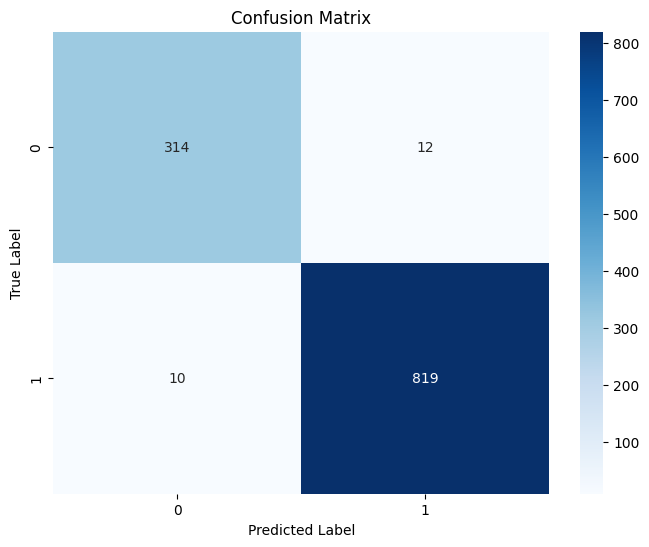

True Positives = 819 
False Positives = 12 
False Negatives = 10 
True Negatives = 314


In [ ]:
# CONFUSION MATRIX XORPSO
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
clf = KNN()
XX=np.array(X)
selected_X = XX[:, sf]
clf.fit(selected_X, y)

vXX=np.array(vX)
selected_VX = vXX[:, sf]
y_pred = clf.predict(selected_VX)


print(classification_report( y_pred,vy, digits=4))
cm = confusion_matrix(y_pred, vy)


# Set the color palette
sns.set_palette("Blues")


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


# disp=ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# Save the plot in eps format
plt.savefig('XORPSO_CONFUSION.eps', format='eps')

# Save the plot in high-quality PNG format
plt.savefig('XORPSO_CONFUSION.png', dpi=300)

# Save the plot in high-quality JPEG format
plt.savefig('XORPSO_CONFUSION.png', dpi=300, )
plt.show()

tn, fp, fn, tp = confusion_matrix(y_pred, vy).ravel()
print( f'True Positives = {tp} \nFalse Positives = {fp} \nFalse Negatives = {fn} \nTrue Negatives = {tn}')

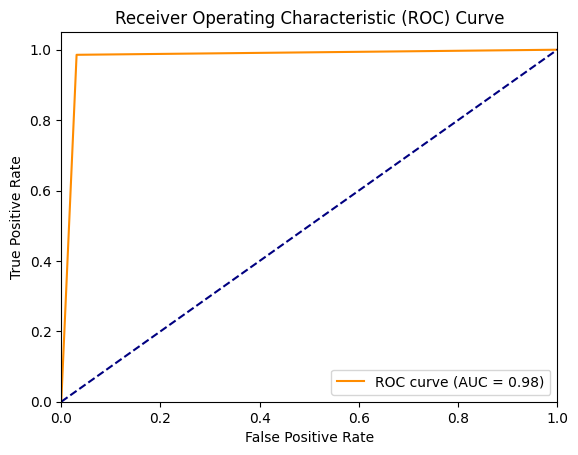

In [ ]:

# ROC XORPSO
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(vy, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





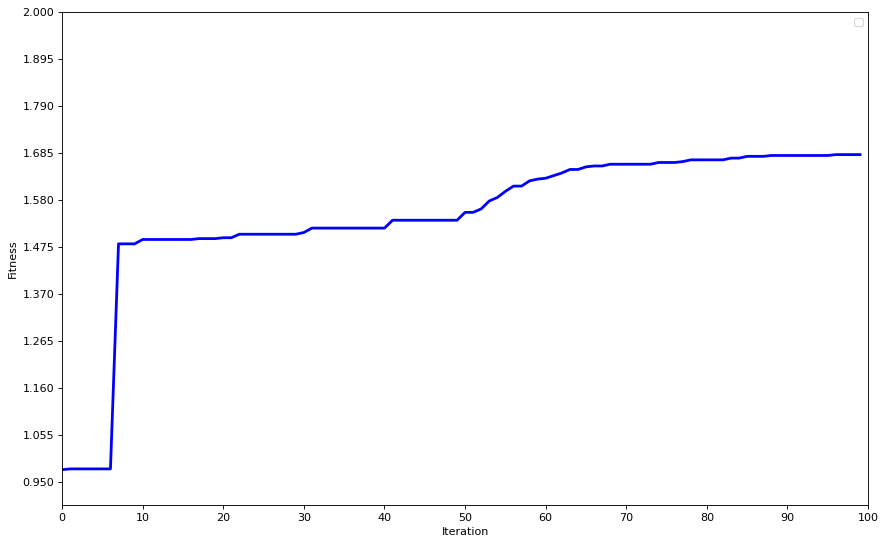

In [ ]:
# FIT XOR PLOTS

plt.figure(figsize=(13, 8), dpi=80)
plt.subplot(111)

plt.plot(fit_curve, color="blue", linewidth=2.5, linestyle="-")

plt.xlim(0, 100)
plt.xticks(np.linspace(0,100, 11))

plt.ylim(0.9, 1.0)
plt.yticks(np.linspace(0.95, 2.0, 11))

plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()

# Save the plot in eps format
plt.savefig('FIT_XORPSO.eps', format='eps')

# Save the plot in high-quality PNG format
plt.savefig('FIT_XORPSO.png', dpi=300)

# Save the plot in high-quality JPEG format
plt.savefig('FIT_XORPSO.png', dpi=300)
plt.show()